<a href="https://colab.research.google.com/github/drcjaudet/Deconvolution3D/blob/master/CycyauTop_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install SimpleITK pydicom tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.1 MB/s eta 0:00:00


#Importation des libraires

In [2]:
import os
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2 as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import copy
import pydicom
import random
import numpy as np
from tqdm import tqdm

#utilise les GPU sinon CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


#importation des images et création la database

In [15]:
#fonction d'importation pour créer la database:

def norm_numpy_matrice(data):
  min_val = np.min(data)
  max_val = np.max(data)
  scaled_data = (data - min_val) / (max_val - min_val)
  #print("Normalisation: ok")
  return scaled_data

# Function to read DICOM files and convert to tensors
def load_dicom_folder(folder_path):
    images = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".dcm") or file_name.endswith(".DCM"):
            file_path = os.path.join(folder_path, file_name)
            ds = pydicom.dcmread(file_path)
            image = sitk.GetArrayFromImage(sitk.ReadImage(file_path))
            image=np.transpose(image, (2,1,0))#l 'image doit être convertie en HWC
            transform_cycy=gettransform()
            image=transform_cycy(image)
            #print(image.shape)
            images.append(image)
    return images

def gettransform():
    transform_cycy = transforms.Compose([
        transforms.ToImage(), #convertie l'image en tensor r numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W)
        transforms.ToDtype(torch.float32, scale=False), #+normalisaiton entre 0 et 1 si Scale=true
        transforms.Lambda(lambda x: x/100), #rajouter la normalisation dasn kes transform normalisation par 1000
         #transforms.Normalize(mean=0.5, std=0.5) #utiliser torch.clamp
    ])
    return transform_cycy

# Function to add Gaussian and Poisson noise
def add_gaussian_poisson_noise(image, gaussian_std=0.1, poisson_lam=10.0):
    gaussian_noise = torch.randn_like(image) * gaussian_std
    poisson_noise = torch.poisson(image * poisson_lam) / poisson_lam - image
    noisy_image = image + gaussian_noise + poisson_noise
    #clip or normalise the image?
    return noisy_image


# Custom Dataset class
class NoisyImageDataset(Dataset):
    def __init__(self, images, transform=None, gaussian_std=0.1, poisson_lam=10.0):
        self.images = images
        self.transform = transform
        self.gaussian_std = gaussian_std
        self.poisson_lam = poisson_lam

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        noisy_image_1 = add_gaussian_poisson_noise(image, self.gaussian_std, self.poisson_lam)
        noisy_image_2 = add_gaussian_poisson_noise(image, self.gaussian_std, self.poisson_lam)

        if self.transform:
            noisy_image_1 = self.transform(noisy_image_1)
            noisy_image_2 = self.transform(noisy_image_2)

        return noisy_image_1, noisy_image_2, image


# Load DICOM images
dicom_folder='/content/2'
images = load_dicom_folder(dicom_folder)

# Define dataset and dataloaders
#transform = transforms.Compose([transforms.Normalize(mean=0.5, std=0.5)])
gaussian_std=0.4 #amplitudedu bruit gaussien sur des images normalisé
poisson_lam=20 #amplitudedu bruit poissonien sur des images normalisé
batch_size=6 #taille du batch
transform_cycy=gettransform()
dataset = NoisyImageDataset(images, transform_cycy, gaussian_std, poisson_lam)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


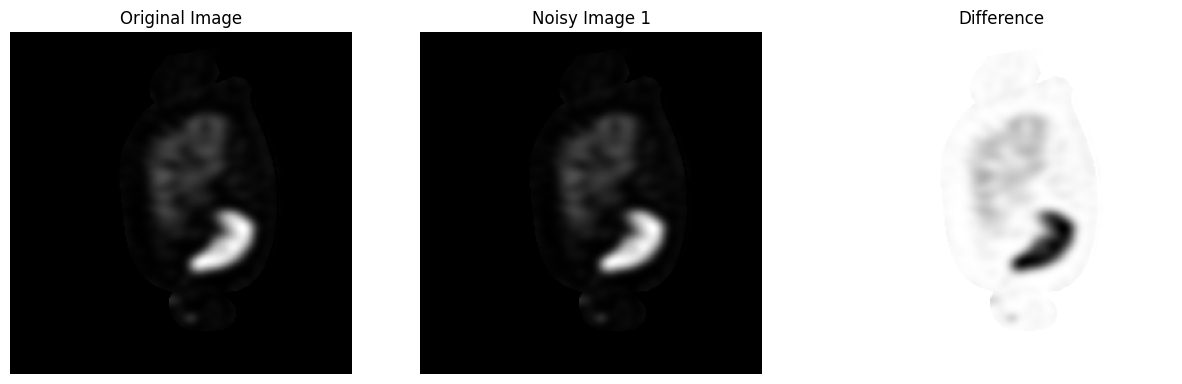

In [16]:
#Visualisation des datasets:
def visualize_image_intiale(dataloader):
    # Get a random batch
    noisy_image_1, noisy_image_2, original_image = next(iter(dataloader))
    #noisy_image_1, _, original_image = dataloader.dataset[1]

    # Select a random image from the batch
    idx = random.randint(0, noisy_image_1.size(0) - 1)
    noisy_image_1 = noisy_image_1[idx]#.unsqueeze(0)
    noisy_image_2 = noisy_image_2[idx]#.unsqueeze(0)
    original_image = original_image[idx]#.unsqueeze(0)

    # Move tensors to CPU and remove channel dimension
    noisy_image_1 = noisy_image_1.squeeze().cpu().numpy()
    noisy_image_2 = noisy_image_2.squeeze().cpu().numpy()
    original_image = original_image.squeeze().cpu().numpy()


    #denoised_image=denoised_image*1000
    #print("Max image debruite:"+str(np.max(denoised_image)))
    #print("Min image debruite:"+str(np.min(denoised_image)))
    #print("Shape image debruite:"+str(denoised_image.shape))
    #print("max image original: "+str(np.max(original_image)))

    # Plot the images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Noisy Image 1")
    plt.imshow(noisy_image_1, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Difference")
    plt.imshow(noisy_image_2-original_image , cmap='gray')
    plt.axis('off')

    plt.show()

# Visualize the denoising
visualize_image_intiale(train_dataloader)

#architecture du model:

In [17]:
# Denoising CNN model
class DenoisingCNN(nn.Module):
    def __init__(self):
        super(DenoisingCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(), #changer to Silu
            nn.Conv2d(64,64, kernel_size=3, padding=1), #utiliser Group norm?
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2)
        )
        self.middle = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        #x = F.interpolate(x, scale_factor=2, mode='nearest') #enlever ainsi que le max pooling
        x = self.decoder(x)
        return x


#entrainement du model:

In [23]:
#creation du model:
# Main training script

def train_denoising_model(train_dataloader, val_dataloader, num_epochs=10 ): # batch_size=20, gaussian_std=0.1, poisson_lam=10.0):
    # Define model, loss function, and optimizer
    model = DenoisingCNN()
    model=model.to(device)
    criterion = nn.MSELoss() # Huber Loss   nn.SmoothL1Loss() instead of nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01) #AdamW ou Adam

    # Training loop with validation and model saving
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_train_loss = 0.0
        for noisy_image_1, noisy_image_2, _ in train_dataloader:
            noisy_image_1, noisy_image_2 = noisy_image_1.to(device), noisy_image_2.to(device)
            optimizer.zero_grad()
            outputs = model(noisy_image_1)
            loss = criterion(outputs, noisy_image_2)
            #print(f'Epoch {epoch+1}/{num_epochs}, Batch Loss: {loss.item():.4f}')
            noisy_image_squeeze = noisy_image_1.squeeze().cpu().numpy()
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for noisy_image_1, noisy_image_2, _ in val_dataloader:
                noisy_image_1, noisy_image_2 = noisy_image_1.to(device), noisy_image_2.to(device)
                outputs = model(noisy_image_1)
                loss = criterion(outputs, noisy_image_2)
                running_val_loss += loss.item()

        epoch_val_loss = running_val_loss / len(val_dataloader)
        val_losses.append(epoch_val_loss)

        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    # Save the best model weights
    torch.save(best_model_wts, 'best_denoising_model.pth')

    # Plot the training and validation losses
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses')
    plt.show()

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    return model, val_dataloader


# Example usage
model, val_dataloader = train_denoising_model( train_dataloader, val_dataloader, num_epochs=10, )



  0%|          | 0/10 [00:03<?, ?it/s]


KeyboardInterrupt: 

torch.Size([1, 256, 256])
Max image debruite:0.0
Min image debruite:0.0
Shape image debruite:(256, 256)
max image original: 1977.0


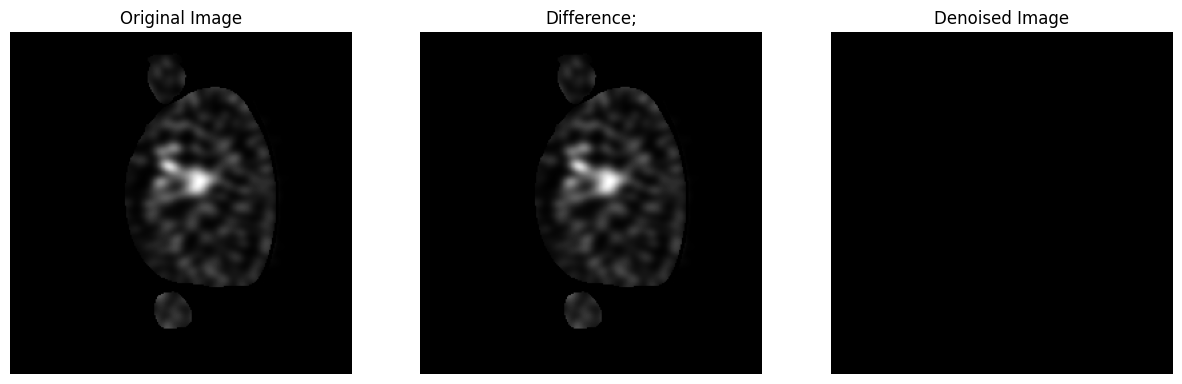

In [20]:

# Function to visualize denoising on a random image
def visualize_denoising(model, dataloader):
    model.eval()
    with torch.no_grad():
        # Get a random batch
        noisy_image_1, noisy_image_2, original_image = next(iter(dataloader))
        #noisy_image_1, _, original_image = dataloader.dataset[1]

        # Select a random image from the batch
        idx = random.randint(0, noisy_image_1.size(0) - 1)
        noisy_image = noisy_image_1[idx]#.unsqueeze(0)
        noisy_image = noisy_image.to(device)
        original_image = original_image[idx]#.unsqueeze(0)

        # Get the denoised image
        denoised_image = model(noisy_image)
        print(denoised_image.shape)

        # Move tensors to CPU and remove channel dimension
        noisy_image = noisy_image.squeeze().cpu().numpy()
        original_image = original_image.squeeze().cpu().numpy()
        denoised_image = denoised_image.squeeze().cpu().numpy()

        #denoised_image=denoised_image*1000
        print("Max image debruite:"+str(np.max(denoised_image)))
        print("Min image debruite:"+str(np.min(denoised_image)))
        print("Shape image debruite:"+str(denoised_image.shape))
        print("max image original: "+str(np.max(original_image)))

        # Plot the images
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(original_image, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Difference;")
        plt.imshow(original_image-denoised_image, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Denoised Image")
        plt.imshow(denoised_image, cmap='gray')
        plt.axis('off')

        plt.show()

# Visualize the denoising
visualize_denoising(model, val_dataloader)

#sauvegarde


In [ ]:
import os
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2 as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import copy
import pydicom
import random
import numpy as np
from tqdm import tqdm

#utilise les GPU sinon CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def norm_numpy_matrice(data):
  min_val = np.min(data)
  max_val = np.max(data)
  scaled_data = (data - min_val) / (max_val - min_val)
  #print("Normalisation: ok")
  return scaled_data

# Function to read DICOM files and convert to tensors
def load_dicom_folder(folder_path):
    images = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".dcm") or file_name.endswith(".DCM"):
            file_path = os.path.join(folder_path, file_name)
            ds = pydicom.dcmread(file_path)
            image = sitk.GetArrayFromImage(sitk.ReadImage(file_path))
            image=np.transpose(image, (2,1,0))#l 'image doit être convertie en HWC
            transform_cycy=gettransform()
            image=transform_cycy(image)
            #print(image.shape)
            images.append(image)
    return images

def gettransform():
    transform_cycy = transforms.Compose([
        transforms.ToImage(), #convertie l'image en tensor r numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W)
        transforms.ToDtype(torch.float32, scale=False), #+normalisaiton entre 0 et 1 si Scale=true
        transforms.Lambda(lambda x: x/1000), #rajouter la normalisation dasn kes transform normalisation par 1000
         #transforms.Normalize(mean=0.5, std=0.5) #utiliser torch.clamp
    ])
    return transform_cycy

# Function to add Gaussian and Poisson noise
def add_gaussian_poisson_noise(image, gaussian_std=0.1, poisson_lam=10.0):
    gaussian_noise = torch.randn_like(image) * gaussian_std
    poisson_noise = torch.poisson(image * poisson_lam) / poisson_lam - image
    noisy_image = image + gaussian_noise + poisson_noise
    #clip or normalise the image?
    return noisy_image

# Custom Dataset class
class NoisyImageDataset(Dataset):
    def __init__(self, images, transform=None, gaussian_std=0.1, poisson_lam=10.0):
        self.images = images
        self.transform = transform
        self.gaussian_std = gaussian_std
        self.poisson_lam = poisson_lam

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        noisy_image_1 = add_gaussian_poisson_noise(image, self.gaussian_std, self.poisson_lam)
        noisy_image_2 = add_gaussian_poisson_noise(image, self.gaussian_std, self.poisson_lam)

        if self.transform:
            noisy_image_1 = self.transform(noisy_image_1)
            noisy_image_2 = self.transform(noisy_image_2)

        return noisy_image_1, noisy_image_2, image

# Denoising CNN model
class DenoisingCNN(nn.Module):
    def __init__(self):
        super(DenoisingCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(), #changer to Silu
            nn.Conv2d(64,64, kernel_size=3, padding=1), #utiliser Group norm?
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2)
        )
        self.middle = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        #x = F.interpolate(x, scale_factor=2, mode='nearest') #enlever ainsi que le max pooling
        x = self.decoder(x)
        return x

# Main training script
def train_denoising_model(dicom_folder, num_epochs=10, batch_size=20, gaussian_std=0.1, poisson_lam=10.0):
    # Load DICOM images
    images = load_dicom_folder(dicom_folder)

    # Define dataset and dataloaders
    #transform = transforms.Compose([transforms.Normalize(mean=0.5, std=0.5)])
    transform_cycy=gettransform()
    dataset = NoisyImageDataset(images, transform_cycy, gaussian_std, poisson_lam)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Define model, loss function, and optimizer
    model = DenoisingCNN()
    model=model.to(device)
    criterion = nn.MSELoss() # Huber Loss   nn.SmoothL1Loss() instead of nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01) #AdamW ou Adam

    # Training loop with validation and model saving
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_train_loss = 0.0
        for noisy_image_1, noisy_image_2, _ in train_dataloader:
            noisy_image_1, noisy_image_2 = noisy_image_1.to(device), noisy_image_2.to(device)
            optimizer.zero_grad()
            outputs = model(noisy_image_1)
            loss = criterion(outputs, noisy_image_2)
            #print(f'Epoch {epoch+1}/{num_epochs}, Batch Loss: {loss.item():.4f}')
            noisy_image_squeeze = noisy_image_1.squeeze().cpu().numpy()
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for noisy_image_1, noisy_image_2, _ in val_dataloader:
                noisy_image_1, noisy_image_2 = noisy_image_1.to(device), noisy_image_2.to(device)
                outputs = model(noisy_image_1)
                loss = criterion(outputs, noisy_image_2)
                running_val_loss += loss.item()

        epoch_val_loss = running_val_loss / len(val_dataloader)
        val_losses.append(epoch_val_loss)

        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    # Save the best model weights
    torch.save(best_model_wts, 'best_denoising_model.pth')

    # Plot the training and validation losses
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses')
    plt.show()

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    return model, val_dataloader


# Example usage
dicom_folder = '/content/2'
model, val_dataloader = train_denoising_model(dicom_folder)




Using device: cuda


 20%|██        | 2/10 [00:50<03:21, 25.15s/it]


KeyboardInterrupt: 

#utilisation du model

In [ ]:
import SimpleITK as sitk
import torch
import numpy as np
import os

# Load DICOM series
def load_dicom_series(directory):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(directory)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    return image

# Apply 2D denoising model to each slice
def denoise_slices(image, model):
    # Convert SimpleITK image to numpy array
    image_np = sitk.GetArrayFromImage(image)
    denoised_slices = []

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No gradient calculation for inference
        for slice in image_np:
            slice_tensor = torch.from_numpy(slice).float().unsqueeze(0).unsqueeze(0)  # Convert to tensor and add batch & channel dimensions
            denoised_slice = model(slice_tensor).squeeze().numpy()  # Apply model
            denoised_slices.append(denoised_slice)

    # Convert list back to numpy array
    denoised_np = np.stack(denoised_slices, axis=0)
    return denoised_np

# Save the processed slices as a new DICOM series
def save_dicom_series(denoised_np, original_image, output_directory):
    # Convert numpy array back to SimpleITK image
    denoised_image = sitk.GetImageFromArray(denoised_np)
    denoised_image.CopyInformation(original_image)  # Copy the metadata from the original image

    # Write the new series
    writer = sitk.ImageFileWriter()
    for i in range(denoised_image.GetDepth()):
        # Extract slice and set correct tags
        slice = denoised_image[:, :, i]
        writer.SetFileName(os.path.join(output_directory, f"denoised_slice_{i:03d}.dcm"))
        writer.Execute(slice)

# Main function to load, process, and save the DICOM series
def main(input_dicom_directory, output_dicom_directory, model):
    model.eval() #enleve les parties just pour l'entrainement du model
    with torch.no_grad(): #enleve la partie calul de gradient
      # Load the DICOM series
      image = load_dicom_series(input_dicom_directory)

      # Apply denoising to each slice
      denoised_np = denoise_slices(image, model)

      # Save the new series
      save_dicom_series(denoised_np, image, output_dicom_directory)
      print("Denoised DICOM series saved successfully.")
    model.train() #repasse en modéle pouvant etre entrainer

# Example usage
if __name__ == "__main__":
    input_dicom_directory = "/path/to/your/dicom/series"
    output_dicom_directory = "/path/to/save/denoised/series"

    # load your model (replace with your actual model)
    model_path = '/content/best_denoising_model.pth'  #a tester
    model=torch.load(model_path)


    # Process the DICOM series
    main(input_dicom_directory, output_dicom_directory, model)


#architecture alternative:

In [21]:
class DenoisingCNN(nn.Module):
    def __init__(self):
        super(DenoisingCNN, self).__init__()

        # Encoder part
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.SiLU(),  # Changed from ReLU to SiLU
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.GroupNorm(8, 64),  # Using Group Normalization with 8 groups
            nn.SiLU()
        )

        # Middle part
        self.middle = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.SiLU(),  # Changed from ReLU to SiLU
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.SiLU()  # Changed from ReLU to SiLU
        )

        # Decoder part
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.SiLU(),  # Changed from ReLU to SiLU
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()  # Output activation for denoising
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

In [ ]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    """(Conv2D -> GroupNorm -> SiLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=out_channels),  # GroupNorm instead of BatchNorm
            nn.SiLU(),  # SiLU activation
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=out_channels),  # GroupNorm
            nn.SiLU()  # SiLU activation
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    """U-Net Architecture for Noise2Noise Denoising."""
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = DoubleConv(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.out_activation = nn.Sigmoid()  # Assuming the output is in the [0, 1] range

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        output = self.out_conv(dec1)
        return self.out_activation(output)

# Example usage of the model
if __name__ == "__main__":
    model = UNet(in_channels=1, out_channels=1)
    input_tensor = torch.randn(4, 1, 256, 256)  # Batch size of 4, single channel, 256x256 resolution
    output_tensor = model(input_tensor)

    print(f"Input shape: {input_tensor.shape}")
    print(f"Output shape: {output_tensor.shape}")


o improve the U-Net model by incorporating a mechanism that explicitly accounts for the blurring in the image, we can integrate additional components to handle the blurred input. A common approach is to use a multi-scale architecture where features are extracted at multiple resolutions. Additionally, we can add a blurred path in parallel with the original path in the encoder, allowing the network to focus on different aspects of the image.

Here's how you could implement this:

    Multi-Scale Feature Extraction: Include downsampling and upsampling operations to capture features at different scales.
    Blur Path in the Encoder: Add an additional path in the encoder where the image is blurred before being processed. This helps the network learn features that are more robust to blurring.

    Key Features of the Improved U-Net:

    Multi-Scale Feature Extraction:
        The network captures both fine and coarse details by processing features at multiple scales.

    Blurred Path:
        A parallel path where the input image is blurred (using average pooling) before being processed through convolutional layers. This path helps the network learn features that are robust to blurring.

    Combined Bottleneck:
        Features from both the original and blurred paths are concatenated before being passed through the bottleneck. This allows the model to integrate information from both paths.

    Skip Connections:
        Skip connections in the U-Net help the network preserve high-resolution details during the decoding process, which is especially useful in denoising tasks.

Next Steps:

This model should be trained using a Noise2Noise approach, where you have pairs of noisy images for training. The network will learn to denoise by leveraging the multi-scale features and the blurred path, making it more effective at handling images with varying degrees of blur.

This architecture provides a more robust approach to handling blurring effects in images, which is often encountered in medical imaging.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(Conv2D -> GroupNorm -> SiLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=out_channels),  # GroupNorm
            nn.SiLU(),  # SiLU activation
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=out_channels),  # GroupNorm
            nn.SiLU()  # SiLU activation
        )

    def forward(self, x):
        return self.double_conv(x)

class UNetWithBlurPath(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNetWithBlurPath, self).__init__()

        # Encoder path
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        # Blurred path
        self.blur_enc1 = DoubleConv(in_channels, 64)
        self.blur_enc2 = DoubleConv(64, 128)
        self.blur_enc3 = DoubleConv(128, 256)
        self.blur_enc4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = DoubleConv(1024, 1024)  # Combining features from both paths

        # Decoder path
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.out_activation = nn.Sigmoid()  # Assuming the output is in the [0, 1] range

    def forward(self, x):
        # Encoder path
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Blurred path
        x_blur = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)  # Simple blurring operation
        blur_enc1 = self.blur_enc1(x_blur)
        blur_enc2 = self.blur_enc2(self.pool(blur_enc1))
        blur_enc3 = self.blur_enc3(self.pool(blur_enc2))
        blur_enc4 = self.blur_enc4(self.pool(blur_enc3))

        # Combining encoder features
        combined_enc4 = torch.cat((enc4, blur_enc4), dim=1)

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(combined_enc4))

        # Decoder path
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, combined_enc4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        output = self.out_conv(dec1)
        return self.out_activation(output)

# Example usage of the model
if __name__ == "__main__":
    model = UNetWithBlurPath(in_channels=1, out_channels=1)
    input_tensor = torch.randn(4, 1, 256, 256)  # Batch size of 4, single channel, 256x256 resolution
    output_tensor = model(input_tensor)

    print(f"Input shape: {input_tensor.shape}")
    print(f"Output shape: {output_tensor.shape}")


I'm glad you liked the previous model! Incorporating a smaller image size of 128x128 and taking into account voxel correlations that follow an Ising model adds another layer of sophistication to your denoising U-Net. The Ising model is typically used in physics to describe interactions between adjacent pixels (or voxels) where each voxel's state (value) is influenced by its neighbors. For image denoising, we can interpret this as considering spatial correlations when predicting the output for each voxel.
Adaptations to the U-Net Model

    Smaller Image Size:
        The U-Net model naturally scales to different input sizes, so adapting it to 128x128 images requires no significant architectural change. However, it does change the receptive field and depth of the network.

    Incorporating Ising Model Correlations:
        We can add additional layers or processing steps to model these correlations explicitly. This might involve using convolutional layers that capture the spatial dependencies or adding custom loss functions that incorporate the Ising model.

Implementation Strategy

    Convolutional Layers:
        Convolutional layers already capture local spatial correlations, so using them effectively with a smaller kernel size and appropriate padding will help.

    Ising-Inspired Loss Function:
        You can create a custom loss function that penalizes outputs that deviate from expected correlations based on the Ising model.

Modified U-Net with Ising Model Consideration

Below is a code snippet implementing these ideas:
Explanation:

    Adapted U-Net Architecture:
        The U-Net model is adjusted for input size 128x128, which is naturally handled by the architecture. The encoder and decoder paths are kept the same, but the receptive field is smaller.

    Ising-Inspired Loss Function:
        ising_loss is a custom loss function that combines the standard Mean Squared Error (MSE) with an additional term inspired by the Ising model. This term penalizes deviations in the differences between neighboring voxels in the output compared to the target, thereby enforcing local correlations.

    Smaller Image Handling:
        The U-Net architecture can handle smaller input sizes directly. With a 128x128 image, the receptive field at the bottleneck will encompass more of the image, making the model sensitive to broader spatial correlations.

Training:

This model can be trained using the ising_loss function, which will help the network learn both the denoising task and maintain the spatial correlations specified by the Ising model. The weighting parameter lam in the loss function can be tuned based on the importance of enforcing these correlations.

This approach should provide a more robust denoising model, especially in scenarios where voxel values are correlated in a way similar to the Ising model.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(Conv2D -> GroupNorm -> SiLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=out_channels),  # GroupNorm
            nn.SiLU(),  # SiLU activation
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=out_channels),  # GroupNorm
            nn.SiLU()  # SiLU activation
        )

    def forward(self, x):
        return self.double_conv(x)

class UNetWithBlurAndIsing(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNetWithBlurAndIsing, self).__init__()

        # Encoder path
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        # Blurred path
        self.blur_enc1 = DoubleConv(in_channels, 64)
        self.blur_enc2 = DoubleConv(64, 128)
        self.blur_enc3 = DoubleConv(128, 256)
        self.blur_enc4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = DoubleConv(1024, 1024)  # Combining features from both paths

        # Decoder path
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.out_activation = nn.Sigmoid()  # Assuming the output is in the [0, 1] range

    def forward(self, x):
        # Encoder path
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Blurred path
        x_blur = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)  # Simple blurring operation
        blur_enc1 = self.blur_enc1(x_blur)
        blur_enc2 = self.blur_enc2(self.pool(blur_enc1))
        blur_enc3 = self.blur_enc3(self.pool(blur_enc2))
        blur_enc4 = self.blur_enc4(self.pool(blur_enc3))

        # Combining encoder features
        combined_enc4 = torch.cat((enc4, blur_enc4), dim=1)

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(combined_enc4))

        # Decoder path
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, combined_enc4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        output = self.out_conv(dec1)
        return self.out_activation(output)

def ising_loss(output, target, lam=0.1):
    """
    Custom loss function incorporating Ising model correlations.
    """
    mse_loss = F.mse_loss(output, target)

    # Ising model term
    output_diff = output[:, :, :-1, :-1] - output[:, :, 1:, 1:]
    target_diff = target[:, :, :-1, :-1] - target[:, :, 1:, 1:]
    ising_loss = F.mse_loss(output_diff, target_diff)

    total_loss = mse_loss + lam * ising_loss
    return total_loss

# Example usage of the model and custom loss function
if __name__ == "__main__":
    model = UNetWithBlurAndIsing(in_channels=1, out_channels=1)
    input_tensor = torch.randn(4, 1, 128, 128)  # Batch size of 4, single channel, 128x128 resolution
    target_tensor = torch.randn(4, 1, 128, 128)  # Noisy target images for Noise2Noise

    output_tensor = model(input_tensor)
    loss = ising_loss(output_tensor, target_tensor)

    print(f"Input shape: {input_tensor.shape}")
    print(f"Output shape: {output_tensor.shape}")
    print(f"Loss: {loss.item()}")


Explanation:

    Exponential Decay:
        The influence between neighboring voxels decays exponentially with distance, as modeled by the weight term. The further a voxel is from the current one, the less it contributes to the loss.
        The beta parameter controls the rate of decay. A higher beta results in a faster decay, meaning that only very close neighbors have significant influence.

    Shifting and Comparison:
        The code uses torch.roll to shift the output and target tensors by different distances (dx, dy), and then compares these shifted tensors to the original. This allows us to account for the influence of neighboring voxels at different distances.
        The MSE between the original and shifted images is weighted by the exponential decay factor and summed across all neighboring distances.

    Integration with MSE:
        The total loss is a combination of the standard MSE loss and the Ising-inspired loss, with the latter weighted by the lam parameter. This allows you to control the relative importance of enforcing spatial correlations in the denoising process.

Usage:

    You can adjust the lam and beta parameters to fine-tune how strongly the Ising model influences the output. The values chosen for these parameters should depend on how much you want to enforce spatial correlations in your specific dataset.

This approach should help to enforce more realistic spatial dependencies in the denoised images, considering that the influence between voxels decreases with distance, as per the Ising model with an exponential decay.


In [ ]:
import torch
import torch.nn.functional as F

def ising_loss(output, target, lam=0.1, beta=0.5):
    """
    Custom loss function incorporating Ising model correlations with exponential decay.

    Parameters:
    - output: the denoised output from the model
    - target: the noisy target image (as used in Noise2Noise)
    - lam: weight of the Ising loss term
    - beta: decay rate for exponential influence with distance

    Returns:
    - total_loss: combined MSE and Ising-inspired loss
    """
    mse_loss = F.mse_loss(output, target)

    # Ising model term with exponential decay
    ising_loss = 0.0

    for dx in range(-2, 3):
        for dy in range(-2, 3):
            if dx == 0 and dy == 0:
                continue  # Skip self-comparison

            distance = abs(dx) + abs(dy)
            weight = torch.exp(-beta * distance)

            output_shifted = torch.roll(output, shifts=(dx, dy), dims=(2, 3))
            target_shifted = torch.roll(target, shifts=(dx, dy), dims=(2, 3))

            ising_loss += weight * F.mse_loss(output, output_shifted)
            ising_loss += weight * F.mse_loss(target, target_shifted)

    total_loss = mse_loss + lam * ising_loss
    return total_loss

# Example usage of the model and custom loss function
if __name__ == "__main__":
    model = UNetWithBlurAndIsing(in_channels=1, out_channels=1)
    input_tensor = torch.randn(4, 1, 128, 128)  # Batch size of 4, single channel, 128x128 resolution
    target_tensor = torch.randn(4, 1, 128, 128)  # Noisy target images for Noise2Noise

    output_tensor = model(input_tensor)
    loss = ising_loss(output_tensor, target_tensor, lam=0.1, beta=0.5)

    print(f"Input shape: {input_tensor.shape}")
    print(f"Output shape: {output_tensor.shape}")
    print(f"Loss: {loss.item()}")
